In [16]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr

import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

C:\Users\eunwon\AppData\Local\Temp/ipykernel_19028/4036209514.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [17]:
import matplotlib
import platform

print(platform.system()) # 플랫폼 확인
# Window
if platform.system() == 'Windows':
    matplotlib.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin': # Mac
    matplotlib.rc('font', family='AppleGothic')
else: #linux
    matplotlib.rc('font', family='NanumGothic')

# 그래프에 마이너스 표시가 되도록 변경
matplotlib.rcParams['axes.unicode_minus'] = False

Windows


In [18]:
# Data load

dataset = read_csv('아파트매매가격지수_경기도.csv',index_col = 0)

df = dataset.T
df

행정구역별,수원시,성남시,의정부시,안양시,부천시,광명시,평택시,동두천시,안산시,고양시,...,이천시,안성시,김포시,화성시,광주시,양주시,여주시,포천시,의왕시,오산시
2013-01-01,63.4,67.8,77.7,60.5,68.1,53.0,92.6,92.6,66.8,69.5,...,89.2,92.6,71.1,73.0,82.4,82.0,102.8,93.6,59.7,83.2
2013-02-01,63.3,67.2,77.4,60.2,67.7,52.9,92.5,90.9,66.6,69.0,...,89.4,92.8,70.9,72.9,82.0,81.7,102.8,93.6,59.1,83.0
2013-03-01,63.2,66.9,76.9,60.0,67.4,52.6,92.4,90.1,66.3,68.6,...,89.7,92.8,70.8,72.8,81.9,81.4,102.7,93.6,58.7,82.9
2013-04-01,63.3,67.1,76.4,59.8,67.4,52.6,92.4,90.0,66.3,68.1,...,90.1,93.5,70.7,73.2,82.3,81.7,102.7,93.9,58.6,82.9
2013-05-01,63.4,67.5,76.4,59.6,67.6,52.9,92.4,89.8,66.6,68.1,...,90.4,93.8,71.0,73.6,82.3,81.9,103.6,94.7,58.8,82.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,108.4,104.3,106.5,110.5,108.7,106.7,111.7,107.3,109.3,106.7,...,107.8,112.6,104.7,110.9,106.8,108.5,105.2,107.3,111.5,114.1
2021-11-01,109.5,104.8,107.2,111.7,110.2,107.3,113.2,107.7,110.7,107.6,...,110.3,114.8,105.3,111.6,107.9,109.5,106.6,108.4,112.9,115.9
2021-12-01,109.8,105.1,107.4,112.0,110.8,107.4,114.1,107.5,111.2,108.0,...,112.3,116.1,105.6,111.6,108.4,109.8,107.2,109.0,113.0,116.7
2022-01-01,109.8,105.1,107.4,111.8,110.8,107.3,114.3,107.5,111.3,108.1,...,113.3,116.9,105.6,111.5,108.7,109.8,107.1,109.2,113.0,116.8


2013-01-01    63.4
2013-02-01    63.3
2013-03-01    63.2
2013-04-01    63.3
2013-05-01    63.4
Name: 수원시, dtype: float64


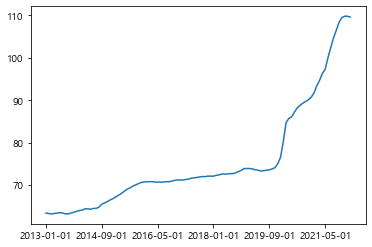

In [19]:
series = df['수원시']
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

In [20]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [21]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test

In [22]:
n_lag = 1
n_seq = 3
n_test = 10
# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)
print(test)
print('Train: %s, Test: %s' % (train.shape, test.shape))

[[ 93.4  94.7  96.3  97.3]
 [ 94.7  96.3  97.3 100. ]
 [ 96.3  97.3 100.  102.4]
 [ 97.3 100.  102.4 104.7]
 [100.  102.4 104.7 106.5]
 [102.4 104.7 106.5 108.4]
 [104.7 106.5 108.4 109.5]
 [106.5 108.4 109.5 109.8]
 [108.4 109.5 109.8 109.8]
 [109.5 109.8 109.8 109.6]]
Train: (97, 4), Test: (10, 4)


In [23]:
# make a persistence forecast
def persistence(last_ob, n_seq):
	return [last_ob for i in range(n_seq)]

# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

t+1 RMSE: 1.781572
t+2 RMSE: 3.442528
t+3 RMSE: 4.994197


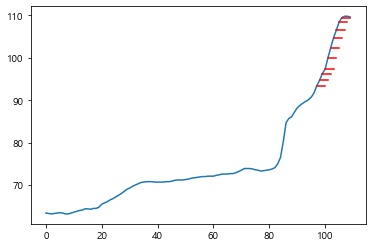

In [24]:
# configure
n_lag = 1
n_seq = 3
n_test = 10
# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)
# make forecasts
forecasts = make_forecasts(train, test, n_lag, n_seq)
# evaluate forecasts
evaluate_forecasts(test, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

In [25]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test
 
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]
 
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts
 
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted
 
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted
 
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
 
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()
 

In [26]:
# configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 1500
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

KeyboardInterrupt: 

In [27]:
df = pd.read_excel('경기도.xlsx')
df

,date,seoul,Avg_1,Avg_2,Avg_3
0,2013-01-01,73.5,64.75625,93.900000,80.100000
1,2013-02-01,73.2,64.42500,93.666667,79.816667
2,2013-03-01,73.1,64.22500,93.550000,79.583333
3,2013-04-01,73.2,64.30000,93.766667,79.516667
4,2013-05-01,73.4,64.49375,94.116667,79.633333
...,...,...,...,...,...
105,2021-10-01,103.5,107.45625,108.650000,108.783333
106,2021-11-01,104.1,108.45625,110.166667,109.833333
107,2021-12-01,104.4,108.79375,111.033333,110.183333
108,2022-01-01,104.4,108.75000,111.383333,110.283333


In [47]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

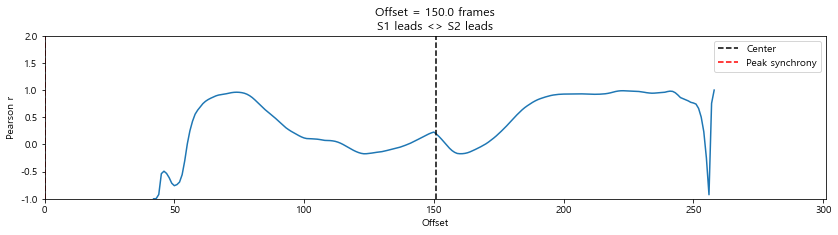

In [48]:
d1 = df['seoul']
d2 = df['Avg_2']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-1,2],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')

plt.legend()

In [49]:
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


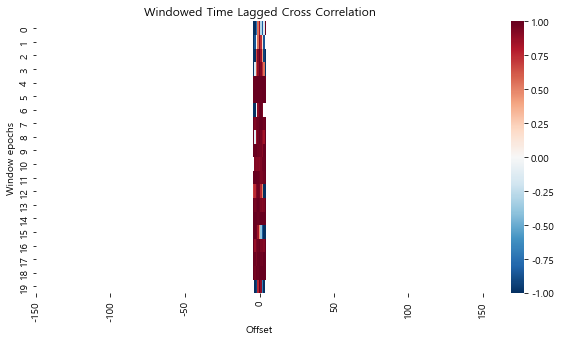

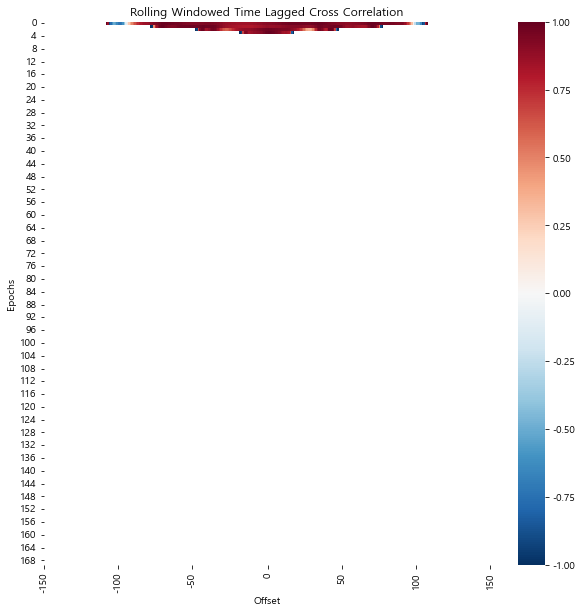

In [43]:
# Windowed time lagged cross correlation
seconds = 5
fps = 30
no_splits = 20
samples_per_split = df.shape[0]/no_splits
rss=[]
for t in range(0, no_splits):
    d1 = df['seoul'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2 = df['Avg_1'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rss.append(rs)
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,301], xlabel='Offset',ylabel='Window epochs')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);

# Rolling window time lagged cross correlation
seconds = 5
fps = 30
window_size = 300 #samples
t_start = 0
t_end = t_start + window_size
step_size = 30
rss=[]
while t_end < 5400:
    d1 = df['seoul'].iloc[t_start:t_end]
    d2 = df['Avg_1'].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,301], xlabel='Offset',ylabel='Epochs')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);

In [35]:
pip install dtw

  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5315 sha256=e4bd9056b781f5ecf0c88d13075d6e871a6d3d33569a8aa13becf8090b25a099
  Stored in directory: c:\users\eunwon\appdata\local\pip\cache\wheels\b4\fe\94\72ad3df3a67605236d3fac0891a64eef2eeedad1a1e0639076
Successfully built dtw
Note: you may need to restart the kernel to use updated packages.


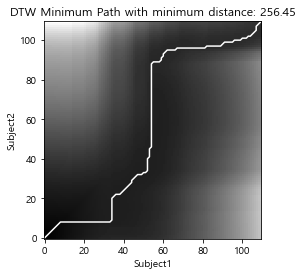

In [39]:
from dtw import dtw,accelerated_dtw

d1 = df['seoul'].interpolate().values
d2 = df['Avg_3'].interpolate().values
d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('Subject1')
plt.ylabel('Subject2')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
plt.show()

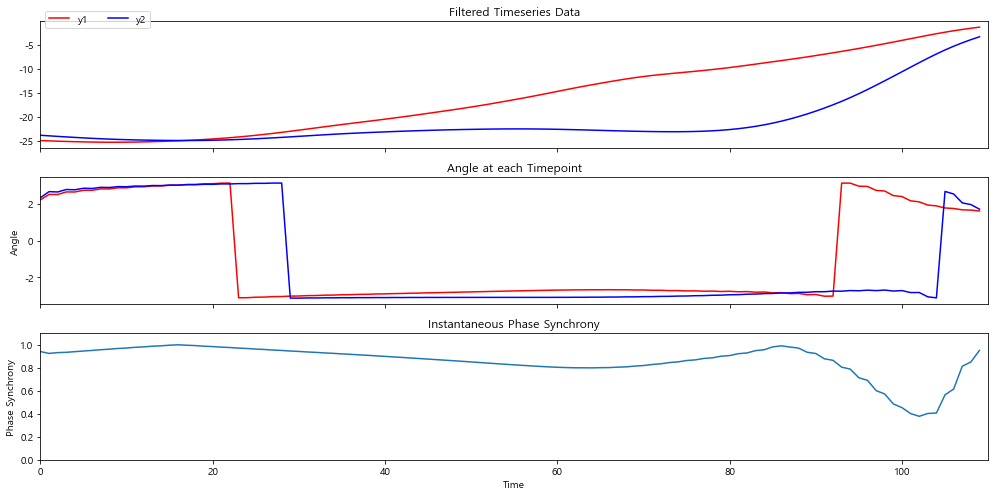

In [50]:
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

lowcut  = .01
highcut = .5
fs = 30.
order = 1
d1 = df['seoul'].interpolate().values
d2 = df['Avg_3'].interpolate().values
y1 = butter_bandpass_filter(d1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
y2 = butter_bandpass_filter(d2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)

al1 = np.angle(hilbert(y1),deg=False)
al2 = np.angle(hilbert(y2),deg=False)
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
N = len(al1)

# Plot results
f,ax = plt.subplots(3,1,figsize=(14,7),sharex=True)
ax[0].plot(y1,color='r',label='y1')
ax[0].plot(y2,color='b',label='y2')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(xlim=[0,N], title='Filtered Timeseries Data')
ax[1].plot(al1,color='r')
ax[1].plot(al2,color='b')
ax[1].set(ylabel='Angle',title='Angle at each Timepoint',xlim=[0,N])
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
ax[2].plot(phase_synchrony)
ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
plt.tight_layout()
plt.show()